# # Smart Voice Assistant For The Blind

In [3]:
# Check and install packages only if needed
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
        print(f"{package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install packages only if missing
install_if_missing("tqdm")
install_if_missing("tensorflow")
install_if_missing("matplotlib")
install_if_missing("pillow")

# Importing the necessary modules
import os
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

print("All packages imported successfully!")

tqdm is already installed
tensorflow is already installed
matplotlib is already installed
Installing pillow...
tensorflow is already installed
matplotlib is already installed
Installing pillow...
All packages imported successfully!
All packages imported successfully!


In [ ]:
# === CUSTOM LAYER DEFINITION (inserted after imports)
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

class NotEqual(Layer):
    """A lightweight shim for the custom NotEqual layer used during training.
    This implements a call that returns element-wise inequality (tf.not_equal).
    If your original training code used a different behaviour, replace this with
    the original class definition from your training notebook/script.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # Expect inputs to be a tuple/list of two tensors (a, b)
        a, b = inputs
        return tf.not_equal(a, b)

    def get_config(self):
        base_config = super().get_config()
        return base_config

# Register so load_model can find 'NotEqual' by name
get_custom_objects()['NotEqual'] = NotEqual
print('Registered custom layer: NotEqual')


In [4]:
# Loading the VGG16 model with optimizations
print("Loading VGG16 model...")
print("Note: This may take a few minutes on first run as it downloads the pre-trained weights")

# Load VGG16 with include_top=False to get features without final classification layer
# This is more efficient than loading full model and then removing layers
model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add global average pooling to get fixed-size feature vectors
from tensorflow.keras.layers import GlobalAveragePooling2D
model = Model(inputs=model.inputs, outputs=GlobalAveragePooling2D()(model.output))

print("VGG16 model loaded successfully!")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

Loading VGG16 model...
Note: This may take a few minutes on first run as it downloads the pre-trained weights
VGG16 model loaded successfully!
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 512)
VGG16 model loaded successfully!
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 512)


In [5]:
BASE_DIR = 'input'
features = {}
directory = os.path.join(BASE_DIR, 'Images')

# Debug: Print paths to verify they're correct
print(f"Base directory: {BASE_DIR}")
print(f"Images directory: {directory}")
print(f"Directory exists: {os.path.exists(directory)}")
if os.path.exists(directory):
    print(f"Number of files in directory: {len(os.listdir(directory))}")

# Check if features already exist
features_file = os.path.join(BASE_DIR, 'features.pkl')
if os.path.exists(features_file):
    print("Loading existing features from pickle file...")
    with open(features_file, 'rb') as f:
        features = pickle.load(f)
    print(f"Loaded features for {len(features)} images")
else:
    print("Extracting features from images...")
    print("This may take a while depending on the number of images...")
    
    # Get list of image files
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Processing {len(image_files)} images...")
    
    # Process images in batches for better memory management
    batch_size = 32
    for i in tqdm(range(0, len(image_files), batch_size), desc="Processing batches", unit="batch"):
        batch_files = image_files[i:i+batch_size]
        batch_images = []
        batch_ids = []
        
        # Load batch of images
        for img_file in batch_files:
            img_path = os.path.join(directory, img_file)
            try:
                image = load_img(img_path, target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)
                batch_images.append(image)
                batch_ids.append(img_file.split('.')[0])
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue
        
        if batch_images:
            # Process batch
            batch_array = np.array(batch_images)
            batch_features = model.predict(batch_array, verbose=0)
            
            # Store features
            for j, image_id in enumerate(batch_ids):
                features[image_id] = batch_features[j:j+1]
    
    # Save features
    print("Saving features to pickle file...")
    with open(features_file, 'wb') as f:
        pickle.dump(features, f)
    print(f"Features saved for {len(features)} images")

Base directory: input
Images directory: input\Images
Directory exists: True
Number of files in directory: 8091
Loading existing features from pickle file...
Loaded features for 8091 images


In [6]:
# load features from the saved pickle file (if not already loaded in previous cell)
if 'features' not in locals() or not features:
    features_file = os.path.join(BASE_DIR, 'features.pkl')
    if os.path.exists(features_file):
        print("Loading features from pickle file...")
        with open(features_file, 'rb') as f:
            features = pickle.load(f)
        print(f"Loaded features for {len(features)} images")
    else:
        print("Features file not found. Please run the previous cell first.")
else:
    print("Features already loaded from previous cell.")

# Debug: Check feature shape
if features:
    sample_key = list(features.keys())[0]
    print(f"Sample feature shape: {features[sample_key].shape}")
    print(f"Feature data type: {features[sample_key].dtype}")

Features already loaded from previous cell.
Sample feature shape: (1, 512)
Feature data type: float32


In [7]:
# Reading the descriptions.txt file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    desc_doc = f.read()

In [8]:
#Mapping the descriptions to the images
mapping = {}
for each_desc in tqdm(desc_doc.split('\n'), desc="Processing captions"):
    tokens = each_desc.split(',')
    if len(each_desc) < 2:
        continue
    image_id, desc_of = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    desc_of = " ".join(desc_of)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(desc_of)

Processing captions: 100%|██████████| 40456/40456 [00:00<00:00, 857353.15it/s]


In [9]:
# Editing the descriptions: Convert to lower case and add beginning and ending
import re

def edit_description(mapping):
    """Clean captions in-place in the mapping dict.
    - lowercases text
    - removes non-alphabet characters
    - collapses whitespace
    - removes 1-letter tokens
    - adds 'beginning' and 'ending' tokens
    """
    for key, desc_list in mapping.items():
        for i in range(len(desc_list)):
            x = desc_list[i].lower()
            # replace any non alphabetic character with a space
            x = re.sub(r'[^a-z\s]', ' ', x)
            # collapse multiple spaces and trim
            x = re.sub(r'\s+', ' ', x).strip()
            # keep words longer than 1 character
            words = [w for w in x.split() if len(w) > 1]
            # ensure we have at least 1 word, otherwise keep a placeholder
            if not words:
                words = ['object']
            desc_list[i] = 'beginning ' + ' '.join(words) + ' ending'

In [10]:
# Calling the preprocessing text function
edit_description(mapping)

In [11]:
# Appending all descriptions into a list: Each image with 5 descriptions
img_desc = []
for key in mapping:
    for caption in mapping[key]:
        img_desc.append(caption)

In [12]:
# Tokenizing the text: finding the unique words from all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(img_desc)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
print("Unique words in the captions are: " + str(vocab_size))

Unique words in the captions are: 8426


In [14]:
# Get the maximum description length for the padding required
max_length = max(len(text.split()) for text in img_desc)
max_length

35

In [15]:
# Splitting the dataset into Training and Testing: 90% is given to training and remaining is for the test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
import tensorflow as tf

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """Yield batches ((X1_array, X2_array), y_array) indefinitely for model.fit.
    X1: image features (float32)
    X2: padded input sequences (int32)
    y: one-hot outputs (float32)
    """
    X1, X2, y = [], [], []
    while True:
        for key in data_keys:
            texts = mapping.get(key, [])
            for t in texts:
                seq = tokenizer.texts_to_sequences([t])[0]
                # skip too short sequences
                if len(seq) < 2:
                    continue
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # append
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    # yield when enough samples accumulated
                    if len(X1) >= batch_size:
                        X1_array = np.array(X1, dtype=np.float32)
                        X2_array = np.array(X2, dtype=np.int32)
                        y_array = np.array(y, dtype=np.float32)
                        # yield as a tuple of arrays (not a list) so TF can infer TypeSpec
                        yield (X1_array, X2_array), y_array
                        X1, X2, y = [], [], []


def count_total_samples(data_keys, mapping, tokenizer, max_length):
    """Count how many training samples will be generated from data_keys.
    Each caption of length L produces (L-1) training samples.
    """
    total = 0
    for key in data_keys:
        texts = mapping.get(key, [])
        for t in texts:
            seq = tokenizer.texts_to_sequences([t])[0]
            if len(seq) >= 2:
                total += (len(seq) - 1)
    return total

In [22]:
# Giving the inputs for the CNN
# Note: VGG16 with GlobalAveragePooling2D outputs 512 features, not 4096

inputs1 = Input(shape=(512,))  # Changed from 4096 to 512 to match VGG16 output
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# Training the model with callbacks and correct steps_per_epoch
epochs = 20
batch_size = 32

print("Preparing training generator...")
train_gen = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# compute total samples and steps per epoch
total_samples = count_total_samples(train, mapping, tokenizer, max_length)
steps_per_epoch = max(1, int(np.ceil(total_samples / batch_size)))
print(f"Total training samples: {total_samples}")
print(f"Steps per epoch: {steps_per_epoch}")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

print("Starting training...")
model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint, early], verbose=1)

# final save (best_model.h5 already saved by checkpoint)
model.save('best_model.h5')
print("Model saved successfully!")

Preparing training generator...
Total training samples: 372297
Steps per epoch: 11635
Starting training...
Epoch 1/20
Total training samples: 372297
Steps per epoch: 11635
Starting training...
Epoch 1/20
11634/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.0646
Epoch 1: loss improved from None to 4.64586, saving model to best_model.h5

Epoch 1: loss improved from None to 4.64586, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 613s 53ms/step - loss: 4.6459
Epoch 2/20
Epoch 2/20
11634/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 4.0052
Epoch 2: loss improved from 4.64586 to 3.94554, saving model to best_model.h5

Epoch 2: loss improved from 4.64586 to 3.94554, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 613s 53ms/step - loss: 3.9455
Epoch 3/20
Epoch 3/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.7547
Epoch 3: loss improved from 3.94554 to 3.72919, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.7547
Epoch 3: loss improved from 3.94554 to 3.72919, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 617s 53ms/step - loss: 3.7292
Epoch 4/20
Epoch 4/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.6162
Epoch 4: loss improved from 3.72919 to 3.61002, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.6162
Epoch 4: loss improved from 3.72919 to 3.61002, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 617s 53ms/step - loss: 3.6100
Epoch 5/20
Epoch 5/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.5393
Epoch 5: loss improved from 3.61002 to 3.53683, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.5393
Epoch 5: loss improved from 3.61002 to 3.53683, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 596s 51ms/step - loss: 3.5368
Epoch 6/20
Epoch 6/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.4877
Epoch 6: loss improved from 3.53683 to 3.48815, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.4877
Epoch 6: loss improved from 3.53683 to 3.48815, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 583s 50ms/step - loss: 3.4881
Epoch 7/20
Epoch 7/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.4561
Epoch 7: loss improved from 3.48815 to 3.45751, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.4561
Epoch 7: loss improved from 3.48815 to 3.45751, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 591s 51ms/step - loss: 3.4575
Epoch 8/20
Epoch 8/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.4282
Epoch 8: loss improved from 3.45751 to 3.42629, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.4282
Epoch 8: loss improved from 3.45751 to 3.42629, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 591s 51ms/step - loss: 3.4263
Epoch 9/20
Epoch 9/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3954
Epoch 9: loss improved from 3.42629 to 3.39508, saving model to best_model.h5
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3954
Epoch 9: loss improved from 3.42629 to 3.39508, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 614s 53ms/step - loss: 3.3951
Epoch 10/20
Epoch 10/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.3863
Epoch 10: loss improved from 3.39508 to 3.38644, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 597s 51ms/step - loss: 3.3864
Epoch 11/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3643
Epoch 11: loss improved from 3.38644 to 3.36639, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 613s 53ms/step - loss: 3.3664
Epoch 12/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3426
Epoch 12: loss improved from 3.36639 to 3.34676, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 616s 53ms/step - loss: 3.3468
Epoch 13/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.3581
Epoch 13: loss did not improve from 3.34676
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 666s 57ms/step - loss: 3.3535
Epoch 14/20
11635/11635 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.3354
Epoch 14: loss improved from 3.34676 to 3.33283, saving model to best_model.h5


11635/11635 ━━━━━━━━━━━━━━━━━━━━ 667s 57ms/step - loss: 3.3328
Epoch 15/20
Epoch 15/20
 8565/11635 ━━━━━━━━━━━━━━━━━━━━ 2:57 58ms/step - loss: 3.3316

In [ ]:
# === SAVE ADDITIONAL ARTIFACTS AFTER TRAINING (inserted after the training cell) ===
import os, pickle

# Try to save in Keras v3 native format (.keras) for better compatibility with Keras 3
try:
    model.save('best_model.keras')
    print("Saved model as best_model.keras")
except Exception as e:
    print('Could not save .keras format (this is OK). Error:', e)

# Save tokenizer and max_length so inference code can reload exact preprocessing
try:
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    with open('max_length.pkl', 'wb') as f:
        pickle.dump(max_length, f)
    print('Saved tokenizer.pkl and max_length.pkl')
except Exception as e:
    print('Failed to save tokenizer/max_length:', e)


In [19]:
def mapping_toword(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [24]:
def predict_description(model, image, tokenizer, max_length):
    in_text = 'beginning'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        desc_predict = model.predict([image, sequence], verbose=0)

        desc_predict = np.argmax(desc_predict)
        word = mapping_toword(desc_predict, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'ending':
            break
      
    return in_text

In [25]:
actual, predicted = list(), list()

for key in tqdm(test):
    desc = mapping[key]
    y_pred = predict_description(model, features[key], tokenizer, max_length) 
    actual_desc = [caption.split() for text in desc]
    y_pred = y_pred.split()
    actual.append(actual_desc)
    predicted.append(y_pred)

100%|██████████| 810/810 [24:57<00:00,  1.85s/it]


In [26]:
!pip install pyttsx3


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# Import required modules for this cell
import matplotlib.pyplot as plt
from PIL import Image

def generate_text(image_name):
    """
    Generate text description for an image and display it
    
    Args:
        image_name (str): Name of the image file (e.g., "23445819_3a458716c1.jpg")
    
    Returns:
        str: Generated text description
    """
    try:
        # Extract image ID from filename
        image_id = image_name.split('.')[0]
        
        # Check if image exists in our dataset
        if image_id not in features:
            return f"Error: Image {image_id} not found in the dataset"
        
        # Load and display the image
        img_path = os.path.join(BASE_DIR, "Images", image_name)
        if not os.path.exists(img_path):
            return f"Error: Image file {image_name} not found"
            
        image = Image.open(img_path)
        
        # Get actual description from mapping (for reference)
        actual_desc = mapping[image_id] if image_id in mapping else "No reference description available"
        
        # Generate predicted description
        y_pred = predict_description(model, features[image_id], tokenizer, max_length)
        
        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image: {image_name}', fontsize=14, pad=20)
        plt.show()
        
        # Print both actual and predicted descriptions
        print("=" * 60)
        print(f"IMAGE: {image_name}")
        print("=" * 60)
        print("ACTUAL DESCRIPTION:")
        if isinstance(actual_desc, list):
            for i, desc in enumerate(actual_desc[:3], 1):  # Show first 3 descriptions
                print(f"{i}. {desc}")
        else:
            print(actual_desc)
        
        print("\nPREDICTED DESCRIPTION:")
        print(y_pred)
        print("=" * 60)
        
        return y_pred
        
    except Exception as e:
        error_msg = f"Error processing image {image_name}: {str(e)}"
        print(error_msg)
        return error_msg

def clean_description(text):
    """
    Clean up the generated description by removing 'beginning' and 'ending' tokens
    and formatting the text properly
    """
    if not text:
        return "No description available"
    
    # Remove 'beginning' and 'ending' tokens
    words = text.split()
    if words and words[0].lower() == 'beginning':
        words = words[1:]
    if words and words[-1].lower() == 'ending':
        words = words[:-1]
    
    # Join words and capitalize first letter
    cleaned_text = ' '.join(words)
    if cleaned_text:
        cleaned_text = cleaned_text[0].upper() + cleaned_text[1:]
    
    return cleaned_text if cleaned_text else "No description available"

In [40]:
def generate_text_only(image_name):
    """
    Generate text description for an image WITHOUT displaying it
    This version doesn't require matplotlib and is useful for voice assistant
    
    Args:
        image_name (str): Name of the image file (e.g., "23445819_3a458716c1.jpg")
    
    Returns:
        str: Generated text description
    """
    try:
        # Extract image ID from filename
        image_id = image_name.split('.')[0]
        
        # Check if image exists in our dataset
        if image_id not in features:
            return f"Error: Image {image_id} not found in the dataset"
        
        # Check if image file exists
        img_path = os.path.join(BASE_DIR, "Images", image_name)
        if not os.path.exists(img_path):
            return f"Error: Image file {image_name} not found"
        
        # Get actual description from mapping (for reference)
        actual_desc = mapping[image_id] if image_id in mapping else "No reference description available"
        
        # Generate predicted description
        y_pred = predict_description(model, features[image_id], tokenizer, max_length)
        
        # Print both actual and predicted descriptions
        print("=" * 60)
        print(f"IMAGE: {image_name}")
        print("=" * 60)
        print("ACTUAL DESCRIPTION:")
        if isinstance(actual_desc, list):
            for i, desc in enumerate(actual_desc[:3], 1):  # Show first 3 descriptions
                print(f"{i}. {desc}")
        else:
            print(actual_desc)
        
        print("\nPREDICTED DESCRIPTION:")
        print(y_pred)
        print("=" * 60)
        
        return y_pred
        
    except Exception as e:
        error_msg = f"Error processing image {image_name}: {str(e)}"
        print(error_msg)
        return error_msg


In [41]:
# Installing the required modules

!pip3 install gTTS pyttsx3 playsound pygobject

  Using cached playsound-1.3.0.tar.gz (7.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pygobject-3.54.3.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      + meson setup C:\Users\pun_y\AppData\Local\Temp\pip-install-02v6ucwy\pygobject_50fbacfbf66249d886faf65be47c0230 C:\Users\pun_y\AppData\Local\Temp\pip-install-02v6ucwy\pygobject_50fbacfbf66249d886faf65be47c0230\.mesonpy-411cfob5 -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md -Dtests=false -Dwheel=true --wrap-mode=nofallback --native-file=C:\Users\pun_y\AppData\Local\Temp\pip-install-02v6ucwy\pygobject_50fbacfbf66249d886faf65be47c0230\.mesonpy-411cfob5\meson-python-native-file.ini
      The Meson build system
      Version: 1.9.1
      Source dir: C:\Users\pun_y\AppData\Local\Temp\pip-install-02v6ucwy\pygobject_50fbacfbf66249d886faf65be47c0230
      Build dir: C:\Users\pun_y\AppData\Local\Temp\pip-install-02v6ucwy\pygobject_50fbacfbf66249d886faf65be47c0230\.mesonpy-411cfob5
      Build type: native build
      Project name: p

In [42]:
pip install SpeechRecognition

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# Setting up the engine for voice to text for input commands
import os
import speech_recognition as sr
import pyttsx3


def voice_output(command):
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()
r = sr.Recognizer()
x = 0



In [44]:
!pip install gTTs


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


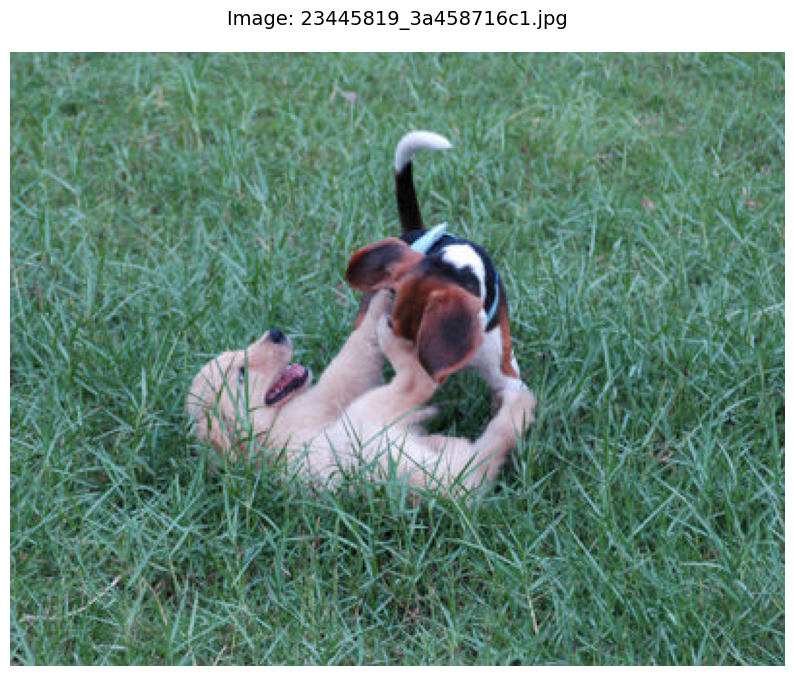

IMAGE: 23445819_3a458716c1.jpg
ACTUAL DESCRIPTION:
1. beginning beagle and golden retriever wrestling in the grass ending
2. beginning two dogs are wrestling in the grass ending
3. beginning two puppies are playing in the green grass ending

PREDICTED DESCRIPTION:
beginning dog is running through the snow ending
beginning dog is running through the snow ending


In [46]:
from gtts import gTTS
from IPython.display import Audio

text = str(generate_text("23445819_3a458716c1.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True) 

In [ ]:
# ในโน้ตบุ๊ก ที่โมเดลถูกสร้างขึ้น
model.save('best_model_tf', save_format='tf')   # จะสร้างโฟลเดอร์ best_model_tf

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('best_model_tf')   # load SavedModel directory

In [ ]:
# === LOAD THE SAVED H5 MODEL FOR INFERENCE (inserted before loading SavedModel) ===
import os, pickle
from tensorflow.keras.models import load_model

h5_path = 'best_model.h5'
caption_model = None
if os.path.exists(h5_path):
    try:
        print(f"Loading caption model from {h5_path} with custom_objects...")
        caption_model = load_model(h5_path, compile=False)
        print('Caption model loaded successfully')
        try:
            caption_model.summary()
        except Exception:
            pass
    except Exception as e:
        print('Failed to load best_model.h5:', e)
        caption_model = None
else:
    print('best_model.h5 not found in project root')

# Load tokenizer and max_length if present
tokenizer_path = 'tokenizer.pkl'
maxlen_path = 'max_length.pkl'
if os.path.exists(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print('Loaded tokenizer.pkl')
else:
    print('tokenizer.pkl not found - ensure tokenizer is saved after training')

if os.path.exists(maxlen_path):
    with open(maxlen_path, 'rb') as f:
        max_length = pickle.load(f)
    print('Loaded max_length.pkl:', max_length)
else:
    print('max_length.pkl not found - ensure it is saved after training')

# You can now use caption_model, tokenizer and max_length for inference


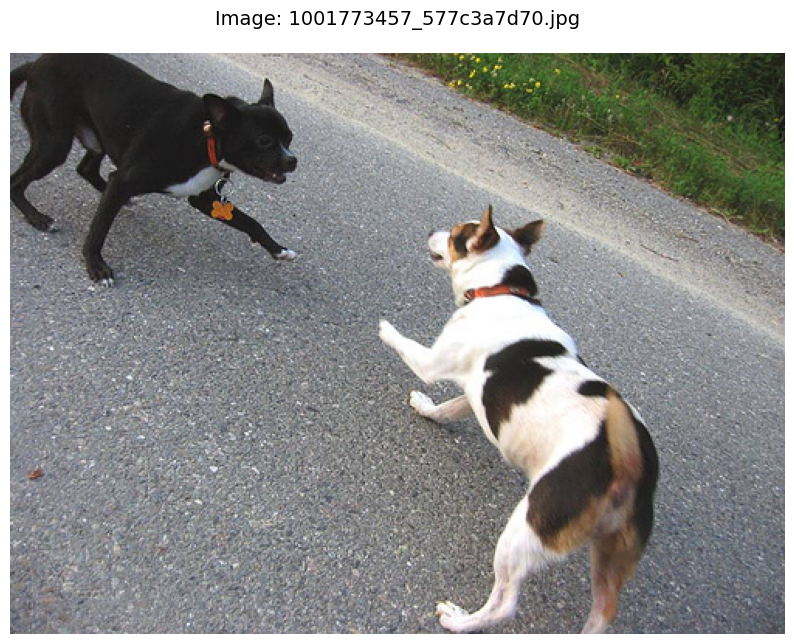

IMAGE: 1001773457_577c3a7d70.jpg
ACTUAL DESCRIPTION:
1. beginning black dog and spotted dog are fighting ending
2. beginning black dog and tri-colored dog playing with each other on the road ending
3. beginning black dog and white dog with brown spots are staring at each other in the street ending

PREDICTED DESCRIPTION:
beginning two dogs are running through the snow ending
beginning two dogs are running through the snow ending


In [47]:
text = str(generate_text("1001773457_577c3a7d70.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

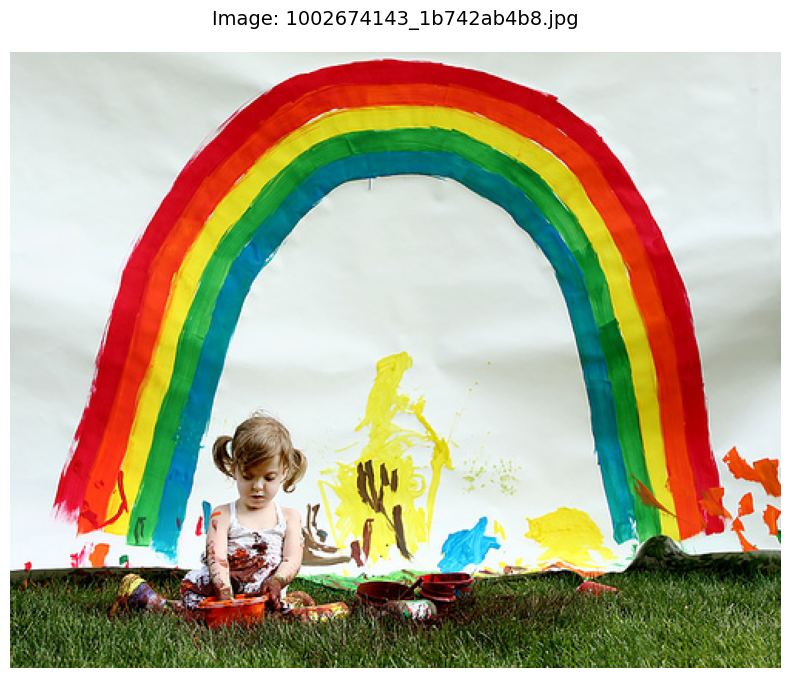

IMAGE: 1002674143_1b742ab4b8.jpg
ACTUAL DESCRIPTION:
1. beginning little girl covered in paint sits in front of painted rainbow with her hands in bowl ending
2. beginning little girl is sitting in front of large painted rainbow ending
3. beginning small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it ending

PREDICTED DESCRIPTION:
beginning man in red shirt and blue jeans is standing on the street ending
beginning man in red shirt and blue jeans is standing on the street ending


In [48]:
text = str(generate_text("1002674143_1b742ab4b8.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

In [49]:
import random
import glob

class VoiceAssistantForBlind:
    """
    A voice assistant designed to help visually impaired users by describing images
    """
    
    def __init__(self):
        self.r = sr.Recognizer()
        self.engine = pyttsx3.init()
        self.setup_voice()
        
    def setup_voice(self):
        """Configure text-to-speech settings"""
        voices = self.engine.getProperty('voices')
        if voices:
            # Use a female voice if available, otherwise use default
            for voice in voices:
                if 'female' in voice.name.lower() or 'zira' in voice.name.lower():
                    self.engine.setProperty('voice', voice.id)
                    break
        
        # Set speech rate and volume
        self.engine.setProperty('rate', 150)  # Speed of speech
        self.engine.setProperty('volume', 0.9)  # Volume level (0.0 to 1.0)
    
    def speak(self, text):
        """Convert text to speech"""
        print(f"Speaking: {text}")
        self.engine.say(text)
        self.engine.runAndWait()
    
    def listen(self):
        """Listen for voice commands"""
        with sr.Microphone() as source:
            print("Listening for your command...")
            self.speak("Listening for your command")
            self.r.adjust_for_ambient_noise(source, duration=1)
            try:
                audio = self.r.listen(source, timeout=5, phrase_time_limit=10)
                text = self.r.recognize_google(audio).lower()
                print(f"You said: {text}")
                return text
            except sr.WaitTimeoutError:
                print("No speech detected within timeout period")
                return None
            except sr.UnknownValueError:
                print("Could not understand the audio")
                self.speak("I didn't understand that. Please try again.")
                return None
            except sr.RequestError as e:
                print(f"Could not request results from speech recognition service: {e}")
                self.speak("Sorry, I'm having trouble with speech recognition right now.")
                return None
    
    def get_random_image(self):
        """Get a random image from the dataset"""
        image_files = [f for f in os.listdir(os.path.join(BASE_DIR, "Images")) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:
            return random.choice(image_files)
        return None
    
    def get_image_by_name(self, image_name):
        """Get a specific image by name"""
        img_path = os.path.join(BASE_DIR, "Images", image_name)
        if os.path.exists(img_path):
            return image_name
        return None
    
    def list_sample_images(self, count=5):
        """List some sample images from the dataset"""
        image_files = [f for f in os.listdir(os.path.join(BASE_DIR, "Images")) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        return random.sample(image_files, min(count, len(image_files)))
    
    def describe_image(self, image_name):
        """Describe an image using the trained model"""
        try:
            # Generate description
            raw_description = generate_text(image_name)
            
            # Clean up the description
            cleaned_description = clean_description(raw_description)
            
            # Speak the description
            self.speak(cleaned_description)
            
            return cleaned_description
            
        except Exception as e:
            error_msg = f"Sorry, I couldn't process that image. {str(e)}"
            print(error_msg)
            self.speak(error_msg)
            return error_msg
    
    def run_assistant(self):
        """Main assistant loop"""
        self.speak("Welcome to the Smart Voice Assistant for the Blind!")
        self.speak("I can help you describe images. Here are some commands you can use:")
        
        print("\n" + "="*60)
        print("VOICE ASSISTANT COMMANDS:")
        print("="*60)
        print("• 'describe random image' - Describe a random image")
        print("• 'describe [image name]' - Describe a specific image")
        print("• 'list images' - List some sample images")
        print("• 'help' - Show available commands")
        print("• 'quit' or 'exit' - Exit the assistant")
        print("="*60)
        
        self.speak("Say 'help' to hear the available commands again.")
        
        while True:
            try:
                command = self.listen()
                
                if not command:
                    continue
                
                if any(word in command for word in ['quit', 'exit', 'goodbye', 'bye']):
                    self.speak("Goodbye! Have a great day!")
                    break
                
                elif 'help' in command:
                    self.speak("Available commands: describe random image, describe specific image name, list images, or quit")
                
                elif 'random' in command and ('image' in command or 'describe' in command):
                    image_name = self.get_random_image()
                    if image_name:
                        self.speak(f"Describing random image: {image_name}")
                        self.describe_image(image_name)
                    else:
                        self.speak("Sorry, no images found in the dataset")
                
                elif 'list' in command and 'image' in command:
                    sample_images = self.list_sample_images()
                    self.speak(f"Here are some sample images: {', '.join(sample_images[:3])}")
                    print("Sample images:", sample_images)
                
                elif 'describe' in command:
                    # Try to extract image name from command
                    words = command.split()
                    image_name = None
                    
                    # Look for image names in the command
                    for word in words:
                        if word.endswith('.jpg') or word.endswith('.jpeg'):
                            image_name = word
                            break
                    
                    if not image_name:
                        # Try to find a potential image ID (numbers and letters)
                        for word in words:
                            if len(word) > 10 and any(c.isdigit() for c in word):
                                # This might be an image ID, try to find the full filename
                                for img_file in os.listdir(os.path.join(BASE_DIR, "Images")):
                                    if word in img_file:
                                        image_name = img_file
                                        break
                                if image_name:
                                    break
                    
                    if image_name:
                        self.speak(f"Describing image: {image_name}")
                        self.describe_image(image_name)
                    else:
                        self.speak("I couldn't find an image name in your request. Please say the full image filename.")
                
                else:
                    self.speak("I didn't understand that command. Say 'help' for available commands.")
                
                # Small pause between commands
                print("\n" + "-"*40 + "\n")
                
            except KeyboardInterrupt:
                print("\nAssistant stopped by user")
                self.speak("Assistant stopped")
                break
            except Exception as e:
                print(f"Error in assistant loop: {e}")
                self.speak("Sorry, something went wrong. Please try again.")

# Create the assistant instance
assistant = VoiceAssistantForBlind()


Testing description for: 23445819_3a458716c1.jpg
--------------------------------------------------


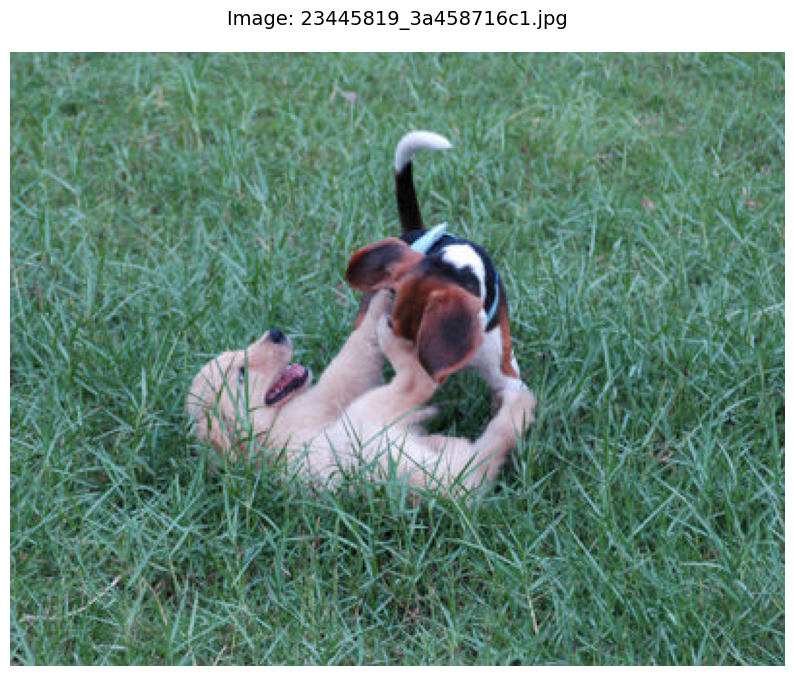

IMAGE: 23445819_3a458716c1.jpg
ACTUAL DESCRIPTION:
1. beginning beagle and golden retriever wrestling in the grass ending
2. beginning two dogs are wrestling in the grass ending
3. beginning two puppies are playing in the green grass ending

PREDICTED DESCRIPTION:
beginning dog is running through the snow ending

RAW DESCRIPTION: beginning dog is running through the snow ending
CLEANED DESCRIPTION: Dog is running through the snow


Testing description for: 1001773457_577c3a7d70.jpg
--------------------------------------------------


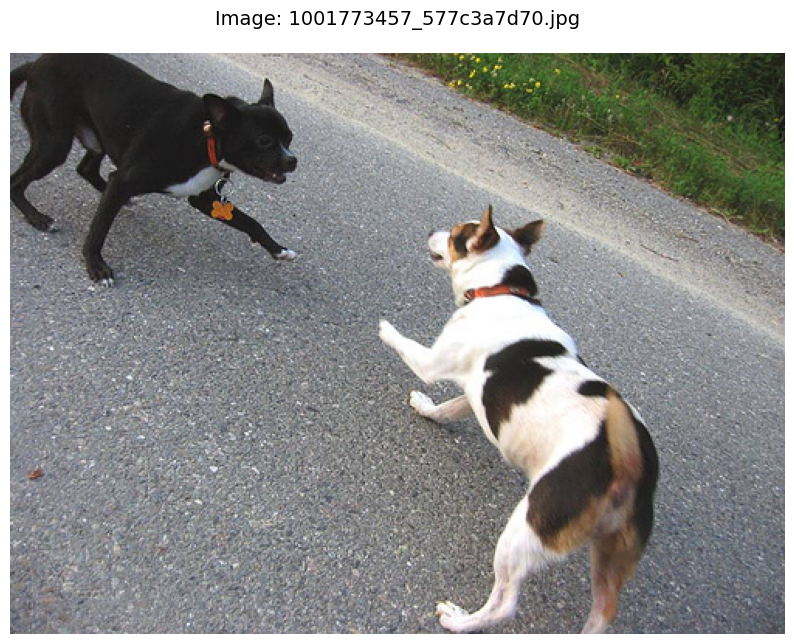

IMAGE: 1001773457_577c3a7d70.jpg
ACTUAL DESCRIPTION:
1. beginning black dog and spotted dog are fighting ending
2. beginning black dog and tri-colored dog playing with each other on the road ending
3. beginning black dog and white dog with brown spots are staring at each other in the street ending

PREDICTED DESCRIPTION:
beginning two dogs are running through the snow ending

RAW DESCRIPTION: beginning two dogs are running through the snow ending
CLEANED DESCRIPTION: Two dogs are running through the snow


Testing description for: 1002674143_1b742ab4b8.jpg
--------------------------------------------------


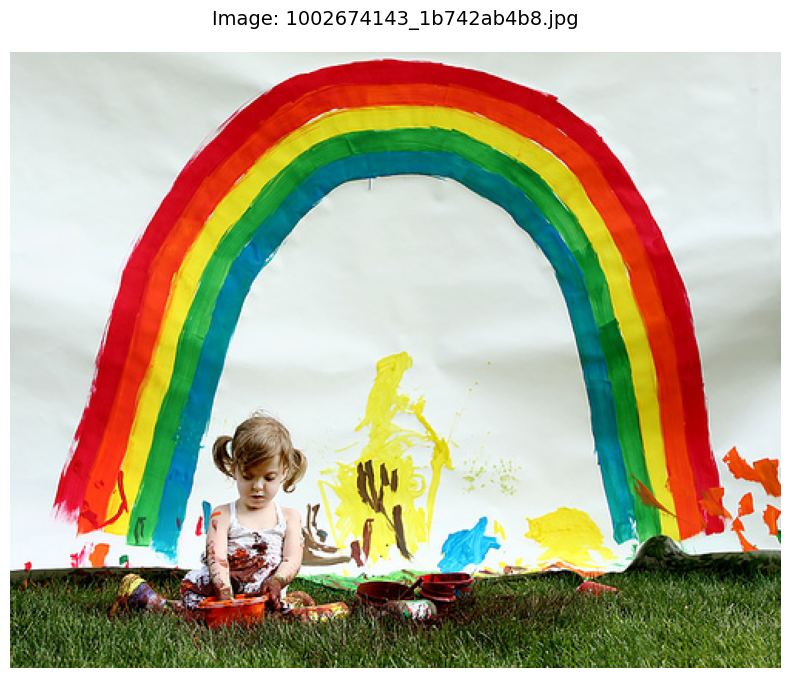

IMAGE: 1002674143_1b742ab4b8.jpg
ACTUAL DESCRIPTION:
1. beginning little girl covered in paint sits in front of painted rainbow with her hands in bowl ending
2. beginning little girl is sitting in front of large painted rainbow ending
3. beginning small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it ending

PREDICTED DESCRIPTION:
beginning man in red shirt and blue jeans is standing on the street ending

RAW DESCRIPTION: beginning man in red shirt and blue jeans is standing on the street ending
CLEANED DESCRIPTION: Man in red shirt and blue jeans is standing on the street




In [50]:
# Test the enhanced functions with cleaned descriptions

def test_image_description(image_name):
    """Test function to demonstrate the enhanced image description"""
    print(f"Testing description for: {image_name}")
    print("-" * 50)
    
    # Generate raw description
    raw_desc = generate_text(image_name)
    
    # Clean the description
    cleaned_desc = clean_description(raw_desc)
    
    print(f"\nRAW DESCRIPTION: {raw_desc}")
    print(f"CLEANED DESCRIPTION: {cleaned_desc}")
    
    return cleaned_desc

# Test with some sample images
test_images = ["23445819_3a458716c1.jpg", "1001773457_577c3a7d70.jpg", "1002674143_1b742ab4b8.jpg"]

for img in test_images:
    if img in [f for f in os.listdir(os.path.join(BASE_DIR, "Images"))]:
        test_image_description(img)
        print("\n" + "="*60 + "\n")
    else:
        print(f"Image {img} not found in dataset")


In [51]:
# Simple command-line interface for testing (alternative to voice interface)

def simple_interface():
    """Simple command-line interface for testing the assistant"""
    print("="*60)
    print("SMART VOICE ASSISTANT FOR THE BLIND - TEXT INTERFACE")
    print("="*60)
    print("Commands:")
    print("1. 'random' - Describe a random image")
    print("2. 'list' - List some sample images")
    print("3. 'describe [image_name]' - Describe specific image")
    print("4. 'quit' - Exit")
    print("="*60)
    
    while True:
        try:
            command = input("\nEnter command: ").strip().lower()
            
            if command in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            
            elif command == 'random':
                image_name = assistant.get_random_image()
                if image_name:
                    print(f"Selected random image: {image_name}")
                    description = test_image_description(image_name)
                    print(f"Description: {description}")
                else:
                    print("No images found")
            
            elif command == 'list':
                sample_images = assistant.list_sample_images()
                print("Sample images:")
                for i, img in enumerate(sample_images, 1):
                    print(f"{i}. {img}")
            
            elif command.startswith('describe '):
                image_name = command.replace('describe ', '').strip()
                if not image_name.endswith('.jpg'):
                    # Try to find the full filename
                    for img_file in os.listdir(os.path.join(BASE_DIR, "Images")):
                        if image_name in img_file:
                            image_name = img_file
                            break
                
                if image_name in [f for f in os.listdir(os.path.join(BASE_DIR, "Images"))]:
                    description = test_image_description(image_name)
                    print(f"Description: {description}")
                else:
                    print(f"Image '{image_name}' not found")
            
            else:
                print("Unknown command. Type 'help' for available commands.")
        
        except KeyboardInterrupt:
            print("\nExiting...")
            break
        except Exception as e:
            print(f"Error: {e}")

# Uncomment the line below to run the simple interface
# simple_interface()


In [52]:
# Demo: Test the voice assistant with a few sample images

print("="*60)
print("DEMO: Smart Voice Assistant for the Blind")
print("="*60)

# Test with a random image
random_image = assistant.get_random_image()
if random_image:
    print(f"Testing with random image: {random_image}")
    
    # Generate description without displaying the image (for demo)
    try:
        image_id = random_image.split('.')[0]
        raw_description = predict_description(model, features[image_id], tokenizer, max_length)
        cleaned_description = clean_description(raw_description)
        
        print(f"Generated description: {cleaned_description}")
        
        # Test the text-to-speech
        print("Converting to speech...")
        assistant.speak(cleaned_description)
        
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "="*60)
print("VOICE ASSISTANT READY!")
print("="*60)
print("To start the voice assistant, run:")
print("assistant.run_assistant()")
print("\nOr for text interface, run:")
print("simple_interface()")
print("="*60)


DEMO: Smart Voice Assistant for the Blind
Testing with random image: 2186139563_e60c1d4b8b.jpg
Generated description: Two dogs are running through the snow
Converting to speech...
Speaking: Two dogs are running through the snow

VOICE ASSISTANT READY!
To start the voice assistant, run:
assistant.run_assistant()

Or for text interface, run:
simple_interface()


In [53]:
# Install missing packages
%pip install matplotlib pillow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
# Test the functions with the sample image
print("Testing image description functions...")

# Test the version without matplotlib display
try:
    description = generate_text_only("23445819_3a458716c1.jpg")
    print(f"Description generated successfully: {description}")
    
    # Clean the description
    cleaned = clean_description(description)
    print(f"Cleaned description: {cleaned}")
    
except Exception as e:
    print(f"Error: {e}")


Testing image description functions...
IMAGE: 23445819_3a458716c1.jpg
ACTUAL DESCRIPTION:
1. beginning beagle and golden retriever wrestling in the grass ending
2. beginning two dogs are wrestling in the grass ending
3. beginning two puppies are playing in the green grass ending

PREDICTED DESCRIPTION:
beginning dog is running through the snow ending
Description generated successfully: beginning dog is running through the snow ending
Cleaned description: Dog is running through the snow


In [55]:
# Simplified version of your original generate_text function
def generate_text(image_name):
    """
    Generate text description for an image (simplified version)
    """
    try:
        image_id = image_name.split('.')[0]
        img_path = os.path.join(BASE_DIR, "Images", image_name)
        
        # Check if image exists
        if not os.path.exists(img_path):
            return f"Error: Image file {image_name} not found"
        
        if image_id not in features:
            return f"Error: Image {image_id} not found in the dataset"
        
        # Get actual description for reference
        desc = mapping.get(image_id, ["No reference description available"])
        
        # Generate predicted description
        y_pred = predict_description(model, features[image_id], tokenizer, max_length)
        
        # Display image if matplotlib is available
        try:
            from PIL import Image
            import matplotlib.pyplot as plt
            
            image = Image.open(img_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f'Image: {image_name}')
            plt.show()
        except ImportError:
            print("Matplotlib not available - skipping image display")
        
        # Print descriptions
        print("=" * 50)
        print(f"Image: {image_name}")
        print("=" * 50)
        print("Reference descriptions:")
        if isinstance(desc, list):
            for i, d in enumerate(desc[:2], 1):  # Show first 2
                print(f"{i}. {d}")
        else:
            print(desc)
        
        print(f"\nGenerated description: {y_pred}")
        print("=" * 50)
        
        return str(y_pred)
        
    except Exception as e:
        error_msg = f"Error processing image {image_name}: {str(e)}"
        print(error_msg)
        return error_msg


Testing the simplified generate_text function...


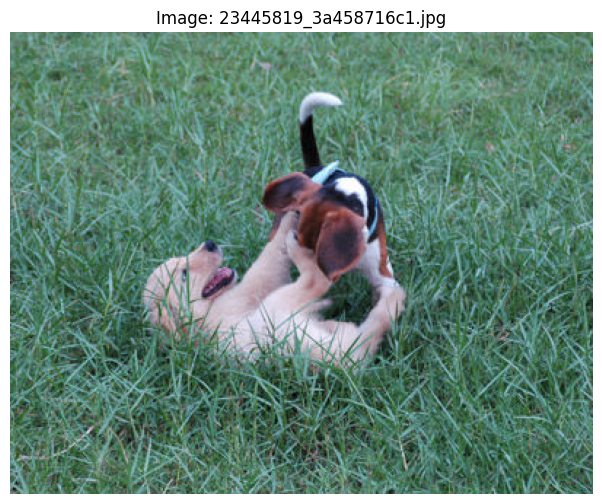

Image: 23445819_3a458716c1.jpg
Reference descriptions:
1. beginning beagle and golden retriever wrestling in the grass ending
2. beginning two dogs are wrestling in the grass ending

Generated description: beginning dog is running through the snow ending

Result: beginning dog is running through the snow ending
Cleaned result: Dog is running through the snow


In [56]:
# Test the simplified generate_text function
print("Testing the simplified generate_text function...")

# Test with your sample image
result = generate_text("23445819_3a458716c1.jpg")
print(f"\nResult: {result}")

# Clean the result
cleaned_result = clean_description(result)
print(f"Cleaned result: {cleaned_result}")
